# Multi-Layer Perceptron (MLP), MNIST
---
<font color='cyan'> Responsible TA: AmirHossein Razlighi </font>

In this notebook, we will train an MLP to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

This is a well-known and famous problem in the machine learning community! We try to train our network to recognize handwritten digits from 0 to 9. We use the famous MNIST dataset for this purpose. The dataset contains 60,000 training images and 10,000 testing images. Each image is a 28x28 grayscale image. We will use the MLP to classify the images.

Let's proceed with the excersise!

In [1]:
# Run this code if you are trying to run the notebook locally
!python3 -m venv ./venv
!source ./venv/bin/activate

The virtual environment was not created successfully because ensurepip is not
available.  On Debian/Ubuntu systems, you need to install the python3-venv
package using the following command.

    apt install python3.10-venv

You may need to use sudo with that command.  After installing the python3-venv
package, recreate your virtual environment.

Failing command: ['/mnt/4b4aaacc-655d-4555-96d5-55b6788ec926/Sharif/term6/AI/AI-Spring-2023/HW8/CE_417_2_Spring23_HW8/Practical/venv/bin/python3', '-Im', 'ensurepip', '--upgrade', '--default-pip']

source: Error encountered while sourcing file “./venv/bin/activate”:
source: No such file or directory


In [ ]:
%pip install torch numpy matplotlib

In [1]:
import torch
import numpy as np

---
## Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

In this cell we first, download the dataset (using torch datasets) and then, create the test_set and train_sets to use in the rest of our notebook.
You can also change the `batch_size` in this cell to your desired amount.

In [7]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

## See some of the training images

First thing to do in any machine learning task is to look at your data! load a batch of images from the training set and display them in a grid using the `imshow` function from `matplotlib.pyplot`. You can also use `torchvision.utils.make_grid` to create a grid from a list of images (batch).

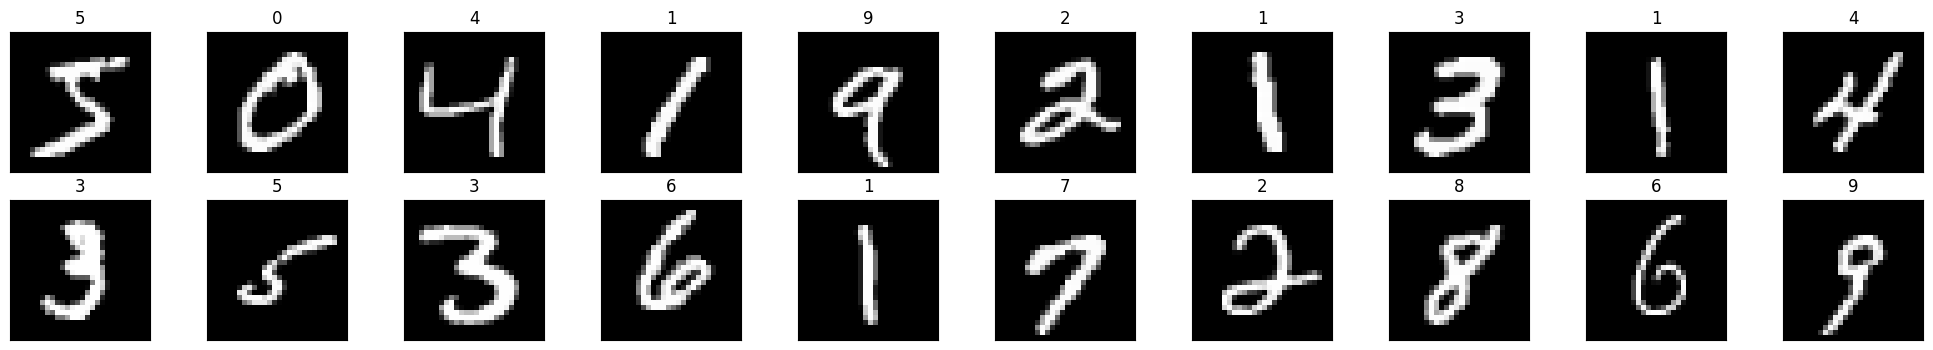

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

#TODO

# obtain one batch of training images


#create a grid and show a batch of images in training data

dataiter = iter(train_loader)
images, labels = next(dataiter)

grid = make_grid(images, nrow=10) 
np_grid = grid.numpy() 
plt.imshow(np.transpose(np_grid, (1, 2, 0)))
plt.show()


## View an Image in More Detail

Here, we look at one sample in a batch to see the pixel values (intensities). Note that our images are grayscale (even if the dataset were in RGB, the color data was irrelevant!) because for detecting the handwritten digits, the color of the ink of pen is not important (obviously)!

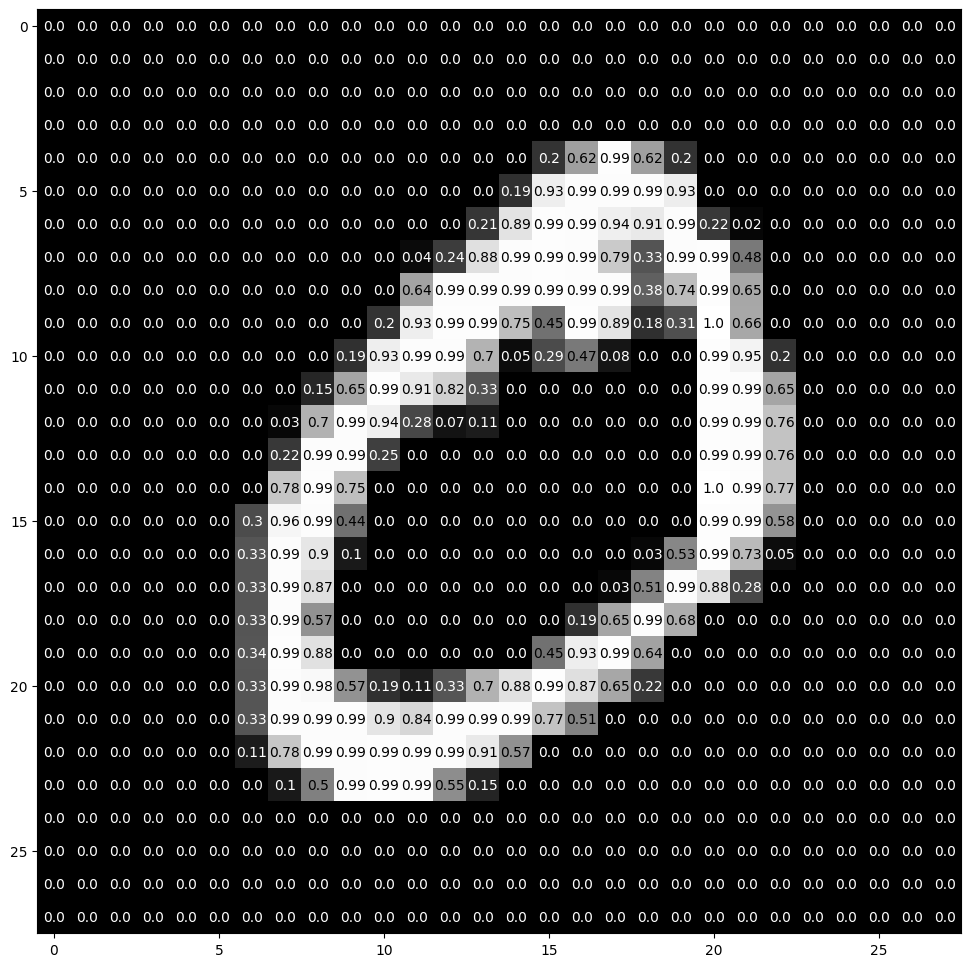

In [41]:
#TODO
# You can round the pixel values with 2 floating point precision for better visualization!

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

In this cell, you should define the network architecture. Note the dimensions of the input (print it out!) and the outputs. Your output should be a tensor of length 10 (digits 0 to 9) that indicates scores (probabilities) for an input image belonging to that class [$P(C_i|x)$]. Use `Drop out` layers to avoid overfitting!

In [42]:
import torch.nn as nn
import torch.nn.functional as F

## Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #TODO

    def forward(self, x):
        #TODO

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


##  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Here you should define the loss function used in training process and the optimizer. We recommend you use `cross-entropy` loss. But you can explore other loss functions if you think they work better in this case! Also, you can use `SGD` or `Adam` optimizer, or any other optimizers that you think would work better!

In [43]:
#TODO
# specify loss function
criterion = ...

#TODO
# specify optimizer
optimizer = ...

---
## Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

Complete the code below:

In [44]:
# number of epochs to train the model
n_epochs = ...  # suggest training between 20-50 epochs

#TODO

Epoch: 1 	Training Loss: 0.971928
Epoch: 2 	Training Loss: 0.414282
Epoch: 3 	Training Loss: 0.371066
Epoch: 4 	Training Loss: 0.349568
Epoch: 5 	Training Loss: 0.335947
Epoch: 6 	Training Loss: 0.326274
Epoch: 7 	Training Loss: 0.318927
Epoch: 8 	Training Loss: 0.313088
Epoch: 9 	Training Loss: 0.308297
Epoch: 10 	Training Loss: 0.304268
Epoch: 11 	Training Loss: 0.300814
Epoch: 12 	Training Loss: 0.297808
Epoch: 13 	Training Loss: 0.295158
Epoch: 14 	Training Loss: 0.292797
Epoch: 15 	Training Loss: 0.290674
Epoch: 16 	Training Loss: 0.288751
Epoch: 17 	Training Loss: 0.286997
Epoch: 18 	Training Loss: 0.285387
Epoch: 19 	Training Loss: 0.283903
Epoch: 20 	Training Loss: 0.282527
Epoch: 21 	Training Loss: 0.281248
Epoch: 22 	Training Loss: 0.280052
Epoch: 23 	Training Loss: 0.278933
Epoch: 24 	Training Loss: 0.277880
Epoch: 25 	Training Loss: 0.276888
Epoch: 26 	Training Loss: 0.275951
Epoch: 27 	Training Loss: 0.275063
Epoch: 28 	Training Loss: 0.274221
Epoch: 29 	Training Loss: 0.2

---
## Test the Trained Network

And at last, you should test the model on test_set (previously unseen data). We will use test_set to evaluate the model's performance. Don't forget to prepare the model for evaluation(testing) using `model.eval()` in Pytorch!

You should report the Test Accuracy of your model.

In [45]:
#TODO


Test Loss: 0.274011

Test Accuracy of     0: 98% (962/980)
Test Accuracy of     1: 97% (1109/1135)
Test Accuracy of     2: 89% (919/1032)
Test Accuracy of     3: 90% (915/1010)
Test Accuracy of     4: 92% (910/982)
Test Accuracy of     5: 87% (781/892)
Test Accuracy of     6: 94% (909/958)
Test Accuracy of     7: 91% (945/1028)
Test Accuracy of     8: 88% (862/974)
Test Accuracy of     9: 90% (914/1009)

Test Accuracy (Overall): 92% (9226/10000)


### Visualize Sample Test Results

This cell displays test images and their labels in this format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

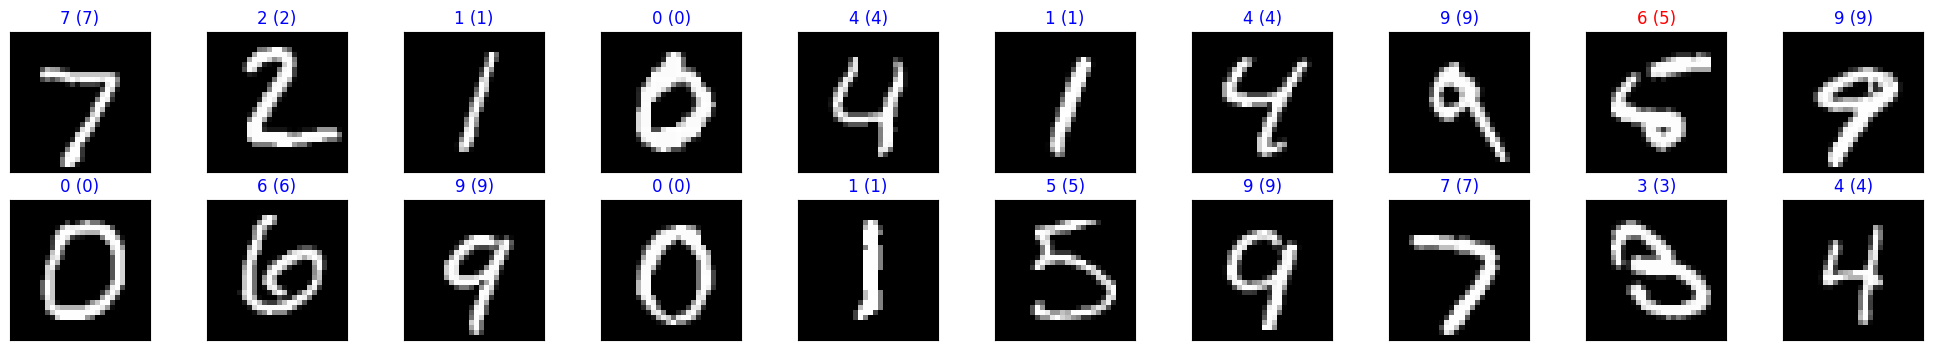

In [51]:
#TODO

# obtain one batch of test images


# get sample outputs

# convert output probabilities to predicted class


# plot the images in the batch, along with predicted and true labels
